In [1]:
import sys
sys.path.append("..")

In [14]:
import os
import glob
import math
import boto3
import yaml
import random
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import Point
from sklearn import decomposition
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray  # noqa: F401
import torch
import stackstac
from pystac_client import Client
import pystac_client
from box import Box
import lancedb
from pathlib import Path
import shapely #.geometry import Point, Polygon, box
from einops import rearrange
from torchvision.transforms import v2
from stacchip.processors.prechip import normalize_timestamp

from src.datamodule import ClayDataModule
from src.model_clay_v1 import ClayMAEModule


In [3]:
def plot_rgb(stack):
    stack.sel(band=[1, 2, 3]).plot.imshow(
        rgb="band", vmin=0, vmax=2000, col_wrap=6
    )
    plt.show()
    
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


def load_model(ckpt, device="cuda"):
    torch.set_default_device(device)

    model = ClayMAEModule.load_from_checkpoint(
        ckpt, metadata_path="../configs/metadata.yaml", shuffle=False, mask_ratio=0
    )
    model.eval()

    return model.to(device)


def prep_datacube(stack, lat, lon, device):
    platform = "naip"

    # Extract mean, std, and wavelengths from metadata
    metadata = Box(yaml.safe_load(open("../configs/metadata.yaml")))
    mean = []
    std = []
    waves = []
    for band in stack.band:
        mean.append(metadata[platform].bands.mean[str(band.values)])
        std.append(metadata[platform].bands.std[str(band.values)])
        waves.append(metadata[platform].bands.wavelength[str(band.values)])

    transform = v2.Compose(
        [
            v2.Normalize(mean=mean, std=std),
        ]
    )

    # Prep datetimes embedding
    datetimes = stack.time.values.astype("datetime64[s]").tolist()
    times = [normalize_timestamp(dat) for dat in datetimes]
    week_norm = [dat[0] for dat in times]
    hour_norm = [dat[1] for dat in times]

    # Prep lat/lon embedding
    latlons = [normalize_latlon(lat, lon)] * len(times)
    lat_norm = [dat[0] for dat in latlons]
    lon_norm = [dat[1] for dat in latlons]

    # Prep pixels
    pixels = torch.from_numpy(stack.data.astype(np.float32))
    pixels = transform(pixels)

    # Prepare additional information
    return {
        "pixels": pixels.to(device),
        "time": torch.tensor(
            np.hstack((week_norm, hour_norm)),
            dtype=torch.float32,
            device=device,
        ),
        "latlon": torch.tensor(
            np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
        ),
        "gsd": torch.tensor(stack.gsd.values, device=device),
        "waves": torch.tensor(waves, device=device),
    }


def generate_embeddings(model, datacube):
    #print(datacube)
    with torch.no_grad():
        unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

    # The first embedding is the class token, which is the
    # overall single embedding. We extract that for PCA below.
    return unmsk_patch[:, 0, :].cpu().numpy()


In [ ]:
STAC_API = "https://planetarycomputer.microsoft.com/api/stac/v1"
PLATFORM_NAME = "naip"


save_dir = "/home/ubuntu/data_naip_test/ca/2020/sf_2/"
os.makedirs(save_dir, exist_ok=True)

YEAR = 2020

search_query = {
    "collections": [PLATFORM_NAME],
    "bbox": [-122.6, 37.6, -122.35, 37.85],  # Part of San Francisco, CA
    "datetime": f"{YEAR}-01-01T00:00:00Z/{YEAR+1}-01-01T00:00:00Z",
}

client = Client.open(STAC_API)

items = client.search(**search_query)

stackstac_datasets = []
granule_names = []

# Iterate over the granule names and fetch the corresponding StackSTAC data arrays
for item in items.get_all_items():
    assets = item.assets
    dataset = rioxarray.open_rasterio(item.assets["image"].href).sel(band=[1, 2, 3, 4])
    granule_name = item.assets["image"].href.split('/')[-1]
    stackstac_datasets.append(dataset)
    granule_names.append(granule_name)
    
    

# Function to tile dataset into 256x256 image chips and drop any excess border regions
def tile_dataset(dataset, granule_name):
    # Reorder dimensions to have (time, band, y, x)
    dataset = dataset.transpose("band", "y", "x")

    # Crop the dataset to remove excess border regions
    cropped_dataset = dataset.isel(x=slice(1, -1), y=slice(1, -1))

    # Determine the number of tiles in x and y dimensions
    num_x_tiles = cropped_dataset.x.size // 256
    num_y_tiles = cropped_dataset.y.size // 256

    # Iterate over each tile
    tiles = []
    tile_names = []
    for x_idx in range(num_x_tiles):
        for y_idx in range(num_y_tiles):
            # Calculate the coordinates for this tile
            x_start = x_idx * 256
            y_start = y_idx * 256
            x_end = x_start + 256
            y_end = y_start + 256

            # Extract the tile from the cropped dataset
            tile = cropped_dataset.isel(x=slice(x_start, x_end), y=slice(y_start, y_end))
            
            # Calculate the centroid
            centroid_x = (tile.x * tile).sum() / tile.sum()
            centroid_y = (tile.y * tile).sum() / tile.sum()
            
            # Print or use the centroid coordinates
            #print("Centroid X:", centroid_x.item())
            #print("Centroid Y:", centroid_y.item())
            
            lon = centroid_x.item()
            lat = centroid_y.item()

            tile = tile.assign_coords(band=['red','green','blue','nir'])
            tile_save = tile

            time_coord = xr.DataArray(['2020-01-01'], dims='time', name='time')

            # Assign the time coordinate to the DataArray
            tile = tile.expand_dims(time=[0])
            tile = tile.assign_coords(time=time_coord)

            gsd_coord = xr.DataArray([0.6], dims='gsd', name='gsd')

            # Assign the time coordinate to the DataArray
            tile = tile.expand_dims(gsd=[0])
            tile = tile.assign_coords(gsd=gsd_coord)

            tile_name = f"{granule_name[:-4]}_{x_idx}_{y_idx}.tif"
            #name_coord = xr.DataArray(tile_name, dims='filename', name='filename')

            # Assign the time coordinate to the DataArray
            #tile = tile.expand_dims(filename=[0])
            #tile = tile.assign_coords(filename=name_coord)

            #print(tile)

            # Save the tile as a GeoTIFF
            tile_path = f"{save_dir}/{granule_name[:-4]}_{x_idx}_{y_idx}.tif"
            tile_save.rio.to_raster(tile_path)
            tiles.append(tile)
            tile_names.append(tile_name)
            
    return tiles, tile_names
    

make_tiles = False

if make_tiles:
    tiles_ = []
    tile_names_ = []
    
    
    # Tile each dataset
    for dataset, granule_name in zip(stackstac_datasets, granule_names):
        tiles, tile_names = tile_dataset(dataset, granule_name)
        tiles_.append(tiles)
        tile_names_.append(tile_names)
    #tiles, tile_names = tile_dataset(stackstac_datasets[0], granule_names[0])
    tiles__ = [tile for tile in tiles for tile_ in tiles_]
    tile_names__ = [tile for tile in tile_names for tile_ in tile_names_]
else:
    tiles__ = []
    tile_names__ = []
    for filename in os.listdir(save_dir):
        if filename.endswith(".tif"):  
            tile_names__.append(filename)
            file_path = os.path.join(save_dir, filename)
            data_array = rioxarray.open_rasterio(file_path)
            tiles__.append(data_array)

In [29]:
len(tiles__)

36024

In [6]:
outdir_embeddings = "/home/ubuntu/data_naip_test/ca/2020/sf_2_embeddings"
os.makedirs(outdir_embeddings, exist_ok=True)

In [11]:
embeddings_.shape

(1, 768)

In [ ]:
#s3://clay-model-ckpt/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt
model = load_model(
    # ckpt="s3://clay-model-ckpt/v0.5.3/mae_v0.5.3_epoch-29_val-loss-0.3073.ckpt",
    ckpt="../checkpoints/v0.5.3/mae_v0.5.3_epoch-08_val-loss-0.3150.ckpt",
    device="cuda",
)
embeddings = []
i = 0
for tile, fname in zip(tiles__, tile_names__):
    # Calculate the centroid
    centroid_x = (tile.x * tile).sum() / tile.sum()
    centroid_y = (tile.y * tile).sum() / tile.sum()
    
    # Print or use the centroid coordinates
    #print("Centroid X:", centroid_x.item())
    #print("Centroid Y:", centroid_y.item())
    
    lon = centroid_x.item()
    lat = centroid_y.item()
    
    datacube = prep_datacube(tile, lat, lon, model.device)
    embeddings_ = generate_embeddings(model, datacube)
    embeddings.append(embeddings_)

    date = tile.time
    data = {
        "source_url": str(fname[:-4]),
        "date": pd.to_datetime(arg=date, format="%Y-%m-%d").astype(
            dtype="date32[day][pyarrow]"
        ),
        "embeddings": [np.ascontiguousarray(embeddings_.squeeze())],
    }

    # Define the bounding box as a Polygon (xmin, ymin, xmax, ymax)
    # The box_ list is encoded as
    # [bottom left x, bottom left y, top right x, top right y]
    box_ = tile.rio.bounds()
    box_emb = shapely.geometry.box(box_[0], box_[1], box_[2], box_[3])

    # Create the GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=[box_emb], crs=f"EPSG:{tile.rio.crs.to_epsg()}")

    # Reproject to WGS84 (lon/lat coordinates)
    gdf = gdf.to_crs(epsg=4326)

    outpath = (
        f"{outdir_embeddings}/"
        f"{fname[:-4]}.gpq"
    )
    gdf.to_parquet(path=outpath, compression="ZSTD", schema_version="1.0.0")
    print(
        f"Saved {len(gdf)} rows of embeddings of "
        f"shape {gdf.embeddings.iloc[0].shape} to {outpath}"
    )
    i=i+1

In [13]:
embeddings[0].shape

(1, 768)

In [4]:
import lancedb
from pathlib import Path

In [7]:
db = lancedb.connect("embeddings")

In [9]:
# Data for DB table
data = []
# Dataframe to find overlaps within
gdfs = []
idx  = 0
for emb in glob.glob(f"{outdir_embeddings}/*.gpq"):
    gdf = gpd.read_parquet(emb)
    gdf["year"] = gdf.date.dt.year
    gdf["tile"] = gdf["source_url"]
    gdf["idx"] = idx
    gdf["box"] = [shapely.geometry.box(*geom.bounds) for geom in gdf.geometry]
    gdfs.append(gdf)

    for _, row in gdf.iterrows():
        data.append(
            {
                "vector": row["embeddings"],
                "path": row["source_url"],
                "tile": row["tile"],
                "date": row["date"],
                "year": int(row["year"]),
                "idx": row["idx"],
                "box": row["box"].bounds,
            }
        )
    idx = idx+1

In [10]:
# Combine patch level geodataframes into one
embeddings_gdf = pd.concat(gdfs, ignore_index=True)

In [11]:
db.drop_table("clay-v001")
db.table_names()

[]

In [ ]:
tbl = db.create_table("clay-v001", data=data, mode="overwrite")

In [16]:
idx = random.randint(0, len(embeddings_gdf))

In [ ]:
v = tbl.to_pandas().iloc[idx]["vector"]

In [18]:
result = tbl.search(query=v).limit(10).to_pandas()

In [19]:
result.path

0    m_3712230_nw_10_060_20200524_21_12
1    m_3712230_nw_10_060_20200524_21_13
2    m_3712230_nw_10_060_20200524_22_12
3    m_3712230_nw_10_060_20200524_20_12
4    m_3712230_nw_10_060_20200524_22_14
5    m_3712230_nw_10_060_20200524_22_13
6    m_3712230_nw_10_060_20200524_21_11
7    m_3712230_nw_10_060_20200524_20_10
8    m_3712230_nw_10_060_20200524_20_11
9    m_3712230_nw_10_060_20200524_20_13
Name: path, dtype: object

In [38]:
def plot(df, cols=10):
    fig, axs = plt.subplots(1, cols, figsize=(20, 10))
    i=0
    for ax, (_, row) in zip(axs.flatten(), df.iterrows()):
        row = df.iloc[i]
        path = row["path"]
        chip = rioxarray.open_rasterio(f"{save_dir}/{path}.tif").sel(band=[1,2,3])
        #chip = tiles__[row["idx"]].sel(band=['red', 'green', 'blue'])
        width = chip.shape[-1]
        height = chip.shape[-1]
        chip = chip.squeeze()
        chip = chip.transpose('x', 'y', 'band')

        ax.imshow(chip)
        ax.set_title(f"{row['idx']}")
        ax.set_axis_off()
        i=i+1
    plt.tight_layout()
    fig.savefig("similar.png")

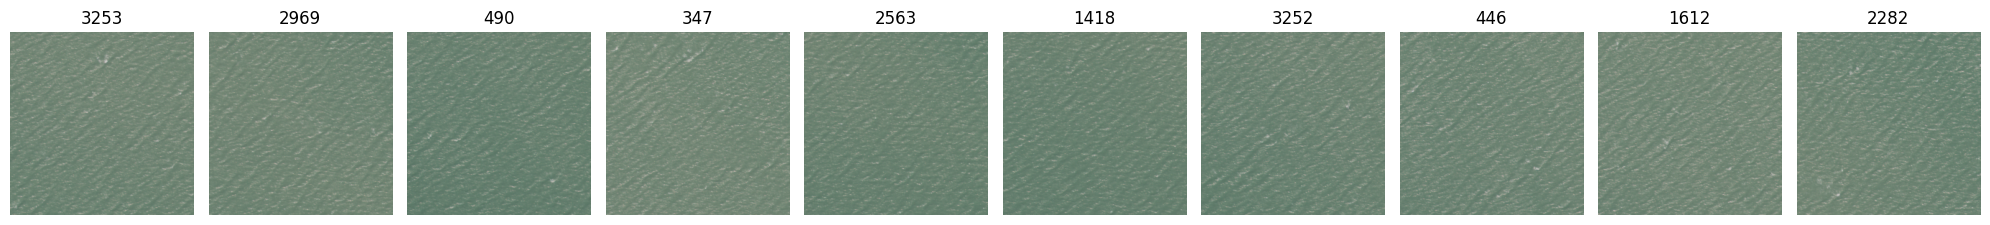

In [39]:
plot(result)

In [41]:
len(embeddings_gdf)

3610